In [54]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Getting and preparing Data

In [1]:
import pathlib
from torchgeo.datasets import LandCoverAI

# Define os agnositc root
dataroot = pathlib.Path("data/landcoverai")

# This doesn't apply any transforms
train_dataset = LandCoverAI(root=dataroot)
val_dataset = LandCoverAI(root=dataroot, split="val")
test_dataset = LandCoverAI(root=dataroot, split="test")



In [2]:
#Sizes
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

7470
1602
1602


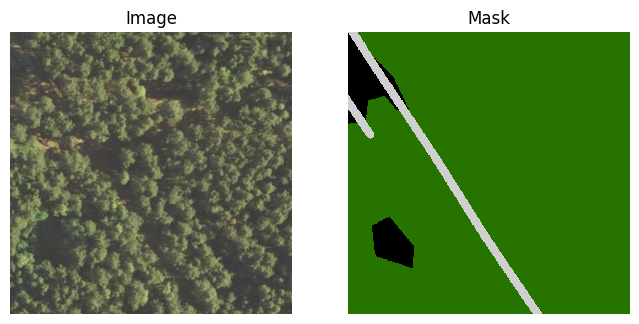

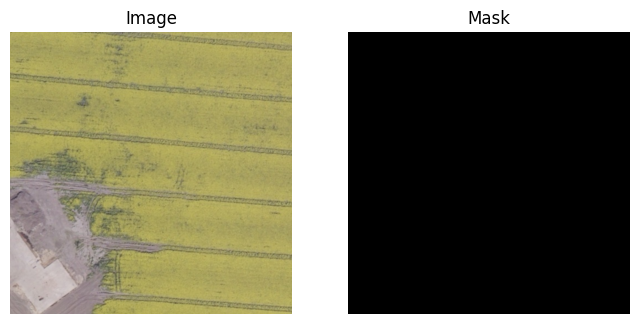

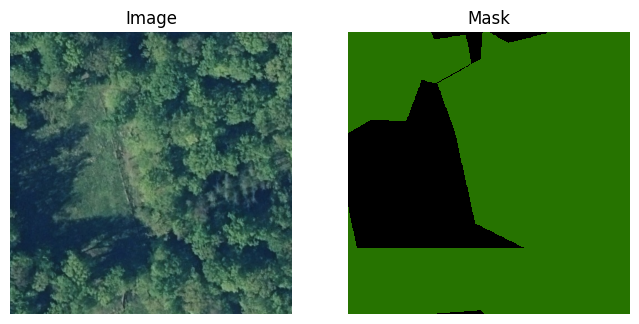

In [3]:
import random
#Let's visualize a few examples
for i in range(3):
    sample = train_dataset[random.randint(0, train_dataset.__len__()- 1)]
    train_dataset.plot(sample)

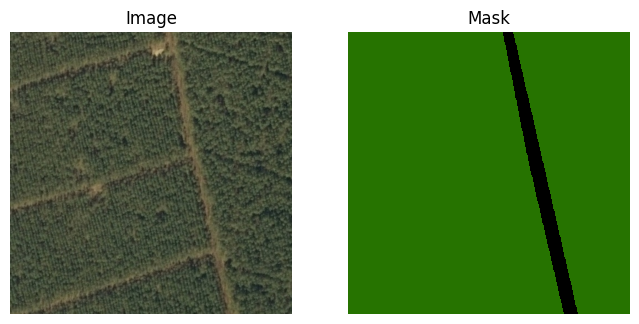

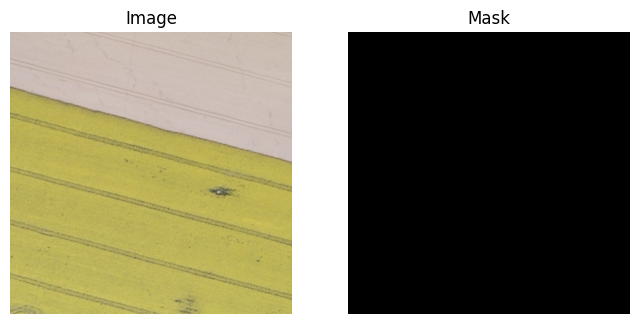

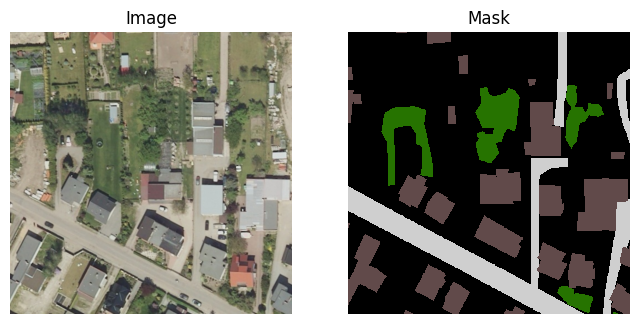

In [4]:
for i in range(3):
    sample = val_dataset[random.randint(0, val_dataset.__len__() - 1)]
    train_dataset.plot(sample)

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor

def compute_mean_std(dataset: Dataset):
    """Compute the mean and standard deviation of a dataset."""
    loader = DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False)
    
    mean = 0.0
    std = 0.0
    n_samples = 0
    
    for data in loader:
        images = data['image']
        batch_samples = images.size(0)  # Batch size (the number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Reshape to (B, C, H*W)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

        print(f"Computed for {n_samples} samples out of {len(dataset)}")
    
    mean /= n_samples
    std /= n_samples
    
    return mean, std

# Use the training dataset to compute mean and std
# mean_train, std_train = compute_mean_std(train_dataset)
mean_train = tensor([ 94.2184, 101.2178,  87.5592])
std_train = tensor([25.8982, 22.9285, 18.8788])

# Use the validation dataset to compute mean and std
# mean_val, std_val = compute_mean_std(val_dataset)
mean_val = tensor([ 95.0307, 102.2367,  88.4823])
std_val = tensor([26.2774, 23.1119, 19.1133])

# Use the test dataset to compute mean and std
# mean_test, std_test = compute_mean_std(test_dataset)
mean_test = tensor([ 92.9187, 100.2754,  87.1114])
std_test = tensor([25.5023, 22.6398, 18.5629])

In [6]:
# Compute overall mean and std with weights corresponding to the number of samples

# Compute the number of samples in each dataset
n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

# Compute the weights
w_train = 1.0 / n_train
w_val = 1.0 / n_val
w_test = 1.0 / n_test

# Compute the mean and std
mean = (w_train * mean_train + w_val * mean_val + w_test * mean_test) / (w_train + w_val + w_test)
std = (w_train * std_train + w_val * std_val + w_test * std_test) / (w_train + w_val + w_test)

# Normalize to [0,1]
MEAN = mean / 255.0
STD = std / 255.0

print(f"Mean: {MEAN}")
print(f"Std: {STD}")


Mean: tensor([0.3686, 0.3971, 0.3442])
Std: tensor([0.1015, 0.0897, 0.0739])


In [7]:
# Reshape mean and std to match the image dimensions
mean = MEAN.view(3, 1, 1)
std = STD.view(3, 1, 1)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([[[0.3686]],

        [[0.3971]],

        [[0.3442]]])
Std: tensor([[[0.1015]],

        [[0.0897]],

        [[0.0739]]])


In [8]:
# Explore shape of the dataset
sample = train_dataset[0]
image = sample["image"]
mask = sample["mask"]
print(f"Original Image Shape: {image.shape}")
print(f"Original Mask Shape: {mask.shape}")

# See scale of images
print(f"Max: {image.max()}")
print(f"Min: {image.min()}")

# See scale of masks
print(f"Max: {mask.max()}")
print(f"Min: {mask.min()}")

Original Image Shape: torch.Size([3, 512, 512])
Original Mask Shape: torch.Size([512, 512])
Max: 209.0
Min: 24.0
Max: 2
Min: 0


Original Image Shape: torch.Size([3, 512, 512]) - Max: 255.0 - Min: 17.0
Scaled Image Shape: torch.Size([3, 512, 512]) - Max: 1.0 - Min: 0.06666667014360428
Original Image Shape: torch.Size([3, 512, 512]) - Max: 199.0 - Min: 4.0
Scaled Image Shape: torch.Size([3, 512, 512]) - Max: 0.7803921699523926 - Min: 0.01568627543747425


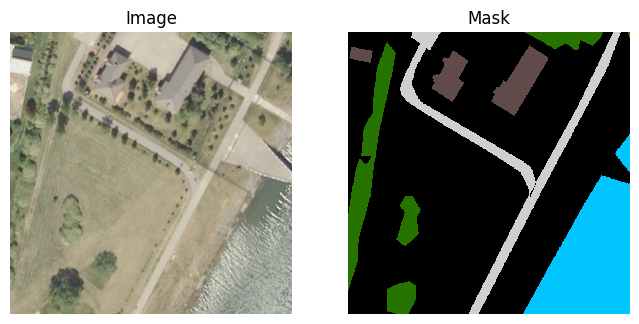

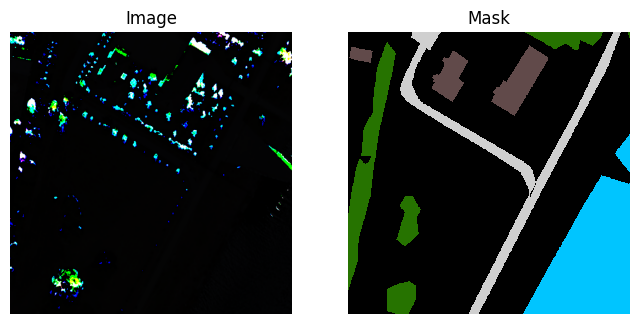

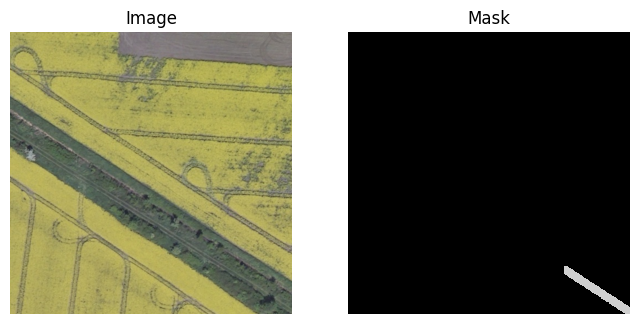

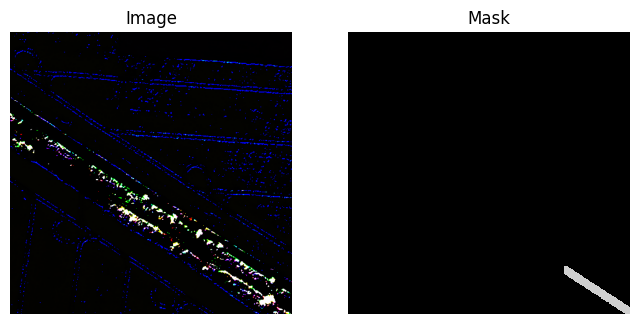

In [9]:
# Plot normalized image and mask
for i in range(2):
    sample = train_dataset[random.randint(0, train_dataset.__len__() - 1)]
    print(f"Original Image Shape: {sample['image'].shape} - Max: {sample['image'].max()} - Min: {sample['image'].min()}")

    # Since mean and std are in [0, 1], and image is in [0, 255], we need to scale image to [0, 1]
    scaled_image = sample["image"] / 255.0
    print(f"Scaled Image Shape: {scaled_image.shape} - Max: {scaled_image.max()} - Min: {scaled_image.min()}")

    # Normalize the image
    normalized_image = (scaled_image - mean) / std
    
    train_dataset.plot(sample)
    train_dataset.plot({
        "image": normalized_image,
        "mask": sample["mask"]
    })

We can see how it helps makes differences 'stand out'